# Data-Efficient Active Learning (DEAL) - N2 decomposition

In this notebook we demonstrate one cycle of data-efficient active learning for molecular simulations, following the methodology described in the DEAL paper and applied to $N_2$ dissociation on FeCo(110) using supporting data from that work.

Goal: Starting from an existing dataset and a pretrained machine learning potential, we identify new training points from MD simulations that are both uncertain and non redundant.

❗ Prerequisites

This notebook assumes that you already have:

1. **A Machine Learning Potential (MLP) trained on an initial dataset.**
    * In this tutorial, we use a MACE model trained on an initial FeCo dataset.
2. **MD trajectories sampling the process of interest.**
    * Here, we assume a LAMMPS MD trajectory for $N_2$ dissociation on FeCo(110) has been generated using the MLP.

**🔁 Active Learning Cycle Overview**

This notebook implements one cycle of active learning with the following steps:

* (a) Train MLP and generate input MD trajectory.

* (b) Pre-selection based on MLP uncertainty.

* (c) DEAL selection via Gaussian Process.

* (d) Single-point DFT calculations.

After: Augment training set and retrain MLP.

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl

from deal import DataConfig, DEALConfig, FlareConfig, DEAL
from deal.utils import load_dataframe, compute_histogram

## (1) Get input data

In this example we use the data from the supporting material of the DEAL paper for the $N_2$ dissociation.

In [2]:
!cd a_input && bash get_data.sh

Trajectory file already present, skipping download.


Load trajectory

In [3]:
from ase.io import read,write

traj_path = 'a_input/traj-std-ev10.xyz'

traj = read(traj_path,index=':')
len(traj)

3001

Load COLVAR

In [9]:
colvar_path = 'a_input/COLVAR'
colvar = None

if colvar_path is not None:
    try:
        colvar = load_dataframe(colvar_path)

        # save colvar into atoms.info
        for i,atoms in enumerate(traj):
            for col in colvar.columns:
                atoms.info['colvar.'+col] = colvar[col].iloc[i]

    except Exception as e:
        print(e)

colvar

,time,coord_Co-Fe,coord_Co-N,coord_Fe-N,dist_N-N,walker
0,0.0,909.672941,6.840348,8.039158,2.860000,0
1,1.0,911.566457,8.090746,9.031735,3.170941,0
2,2.0,902.426518,7.771793,8.485276,3.252242,0
3,3.0,899.776088,7.600493,8.571635,2.971926,0
4,4.0,901.665373,6.635382,7.309394,1.953947,0
...,...,...,...,...,...,...
2996,2996.0,905.339467,6.936880,7.915974,3.243602,0
2997,2997.0,904.952976,7.049138,8.058686,2.893873,0
2998,2998.0,903.516148,7.353886,8.438719,2.963127,0
2999,2999.0,903.878526,7.598940,8.682715,2.970138,0


## (b) Pre-selection

Pre-select high uncertainty configurations, e.g. via query-by-committee

In [10]:
uncertainty_key = 'force_std_comp_max' # key of array

threshold = 0.09 # None
max_threshold = 3*threshold

if threshold is not None:
    try:
        # define uncertainty of a frame as the max uncertainty on force components
        uncertainty = np.asarray([atoms.get_array(uncertainty_key).max() for atoms in traj])
        # save it in atoms.info
        for i,atoms in enumerate(traj):
            atoms.info['uncertainty'] = uncertainty[i]
            
        preselection = ( uncertainty > threshold ) & ( uncertainty < max_threshold )

        print(f'Preselection by uncertainty: {preselection.sum()}/{len(traj)} frames')

    except Exception as e:
        print('No preselection: uncertainty not found.')
        preselection = np.ones(len(traj),dtype=bool)

Preselection by uncertainty: 1743/3001 frames


Shuffling (reccomended). This can also be done later in the Data Config of DEAL.

In [11]:
# shuffle trajectory
shuffle = True
seed = 42 

# save the original frame no in atoms.info
for i,atoms in enumerate(traj):
    atoms.info['frame'] = i

idx = np.argwhere(preselection)[:,0]
if shuffle:
    np.random.seed(seed)
    np.random.shuffle(idx)
    print('Shuffled')

traj_input = [traj[i] for i in idx]

Shuffled


Write trajectory

In [12]:
deal_input_traj = f'b_preselection/traj-preselection.xyz'
write(f'{deal_input_traj}',traj_input)

/home/lbonati@iit.local/software/miniforge3-mamba/envs/deal/lib/python3.12/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


## (c) DEAL selection 

### Run DEAL from Python 
**(SKIP THIS STEP IF YOU RUN FROM THE COMMAND LINE, see below)**

Use the configuration objects (`DataConfig`, `DEALConfig` and `FlareConfig` to specify the settings. 
The COLVAR path is optional; when provided it is passed to the chemiscope writer so CVs appear in the viewer.

#### Choice of the parameters

**Descriptors**

Local environments are characterized via the Atomic Cluster Expansion formalism as implemented in `flare`. Key hyperparameters: body order (`B1/B2`), radial degree `nmax`, angular degree `lmax`, and cutoff (in Å). Set `verbose=True` to see defaults.

**Threshold**

The`threshold` parameter in the DEAL configuration controls when a local environment is flagged by the SGP’s predictive variance (normalized by the noise hyperparameter). If any environment exceeds the threshold, the GP is updated and that environment (plus any others above `update_threshold * threshold`) is added. 

Some tips:

- A good starting point is around 0.1.
- Try a few values and compare how many structures are selected; distributions often are very similar across thresholds, what changes is the number of structures.
- For active learning of ML potentials a possible practical strategy is to pick an initial threshold, run the single-point calculations on the selected structure, update the potential, and then evaluate it on configurations chosen with a tighter threshold to ensure that they are well  described, otherwise expand the training set with them.  

In [ ]:
# set DEAL parameters
cutoff = 5
deal_thresholds = [0.15,0.1,0.05]

deal_folder = 'selection'

for deal_threshold in deal_thresholds:
    output_prefix = f'{deal_folder}/deal_{deal_threshold:.3f}'

    data_cfg = DataConfig(
        files=deal_input_traj,
        format='extxyz',
        index=':',
        shuffle=False, # already shuffled
        colvar=None,   # colvar_path colvar info already in atoms.info,
        )

    deal_cfg = DEALConfig(
        threshold=deal_threshold,
        max_atoms_added=0.15,       # fraction of total atoms to add at each iteration 
        initial_atoms=0.2,          # use up to 20% of the atoms of each species for initial training
        output_prefix=output_prefix,
        verbose=False,
    )

    flare_cfg = FlareConfig(cutoff=cutoff)

    deal = DEAL(data_cfg, deal_cfg, flare_cfg)
    # uncomment to run
    # deal.run()

### CLI equivalent 
The same run can be launched from the command line using the YAML `input.yaml` which will run the three thresholds:

```bash
deal -c input.yaml
```
Consider running it on a HPC cluster or on a high-memory machine: below an example SLURM script to run DEAL on CSCS.
Make sure to adjust the number of nodes, tasks and cpus per task according to your system and the size of your dataset.


```bash
#!/bin/bash -l
#========================================
#SBATCH --account=xxxxxx          # account to be charged
#========================================
# #SBATCH --partition=debug         # partition to be used
#SBATCH --time 24:00:00             # format: HH:MM:SS
#========================================
#SBATCH --nodes=1                   # node
#SBATCH --ntasks-per-node=16        # MPI
#SBATCH --cpus-per-task=16          # openMP
#SBATCH --hint=nomultithread
#SBATCH --hint=exclusive
#========================================
#SBATCH --uenv=prgenv-gnu/25.6:v2
#SBATCH --view=modules
#========================================
## to submit the job, use:
# sbatch this_script.sh

#========================================
export OMP_NUM_THREADS=16
export OMP_PLACES=cores
ulimit -s unlimited
#========================================
# load modules (load the module used to install DEAL and its dependencies)
module load gcc/14.2.0 openblas/0.3.29
conda activate deal
#========================================
# Run DEAL 
deal -c input.yaml > deal.log 2>&1         # run deal

# END OF SCRIPT
```


### Analyze

In [16]:
deal_thresholds = [0.05,0.1,0.15]

traj_deals = {}

print('DEAL Selection')
traj_all = read(f'b_preselection/traj-preselection.xyz',index=':')
for deal_threshold in deal_thresholds:
    try:
        traj = read(f'c_selection/deal_{deal_threshold}_selected.xyz',index=':')
        traj_deals[deal_threshold] = traj
        print(f'Threshold {deal_threshold:.3f}: {len(traj)}/{len(traj_all)} structures')
    except Exception as e:
        print(e)

colors = mpl.colormaps['fessa'](np.linspace(0, 1, len(traj_deals)))

DEAL Selection
Threshold 0.050: 305/1743 structures
Threshold 0.100: 147/1743 structures
Threshold 0.150: 92/1743 structures


We can analyze the configurations selected with different thresholds to decide which set to recalculate at the DFT level, e.g. based on the number of DFT calculations. As you see below the distribution of selected structures is very similar. 

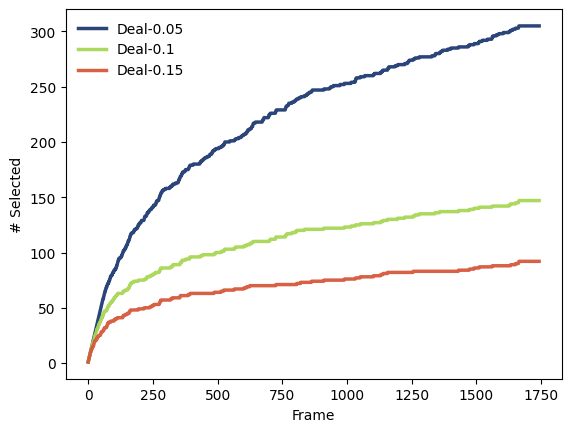

In [21]:
fig, ax = plt.subplots()

for k,(deal_threshold,traj_deal) in enumerate(traj_deals.items()):
    selected_ids = [ atoms.info['step'] for atoms in traj_deal ]
    selection_curve = [np.sum(np.asarray(selected_ids)<=i) for i in range(len(traj_all))]
    ax.plot(selection_curve,label=f'Deal-{deal_threshold}',linewidth=2.5,alpha=0.95, color=colors[k])

ax.set_xlabel('Frame')
ax.set_ylabel('# Selected')
ax.legend(frameon=False)

Histogram vs CVs

Available CVs: ['energy', 'uncertainty', 'frame', 'colvar.time', 'colvar.coord_Co-Fe', 'colvar.coord_Co-N', 'colvar.coord_Fe-N', 'colvar.dist_N-N', 'colvar.walker']


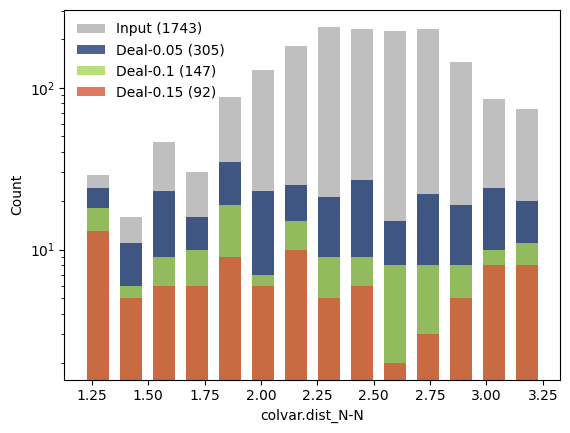

In [22]:
print("Available CVs:",[c for c in traj_all[0].info.keys() ])

cv_name = 'colvar.dist_N-N'

fig, ax = plt.subplots()
cv_all = np.asarray([atoms.info[cv_name] for atoms in traj_all])
bins_cv = np.linspace(cv_all.min(),cv_all.max(),15)
x,h = compute_histogram(cv_all,bins=bins_cv)
ax.bar(x,h,width=(x[1]-x[0])/1.5,label=f'Input ({len(traj_all)})',alpha=0.5,color='grey',zorder=0)
#for xi,hi in zip(x,h):
    #ax.text(xi,hi+5,f'{hi}', horizontalalignment= 'center', color='grey')

for k,(deal_threshold,traj_deal) in enumerate(traj_deals.items()):
    cv_deal = np.asarray([atoms.info[cv_name] for atoms in traj_deal])
    x,h = compute_histogram(cv_deal,bins=bins_cv)
    ax.bar(x,h,width=(x[1]-x[0])/1.5,label=f'Deal-{deal_threshold} ({len(traj_deal)})',alpha=0.8,color=colors[k],zorder=0)
    #for xi,hi in zip(x,h):
        #ax.text(xi-dx/5,hi+5,f'{hi}',color=colors[k])

ax.set_xlabel(cv_name)
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.legend(frameon=False)
plt.show()

We can also visualize the selected configurations using chemiscope:

In [23]:
import chemiscope
chemiscope.show_input('c_selection/deal_0.1_chemiscope.json.gz')

<ChemiscopeWidget(meta={'name': 'DEAL selection'}, settings={'structure': [{'atoms': False, 'bonds': False, 's…

## (d) Single point and retrain MLP

In the paper we used a threshold of 0.1, and after performing the DFT calculations of approx. 130 structures, this resulted in a uniformly accurate model along the CV, as measured by the uncertainty on a new MD run performed with the new model (panel c below).

![](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41524-024-01481-6/MediaObjects/41524_2024_1481_Fig4_HTML.png)